In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms, models # type: ignore
import matplotlib.pyplot as plt
import seaborn as sns # type: ignore
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
from PIL import Image
from collections import defaultdict
from datetime import datetime

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
import pickle
import os

def unpickle(file):
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict

# Assuming the extracted files are in the directory 'cifar-10-batches-py'
data_path = 'cifar-10-batches-py'
batch_files = [f'data_batch_{i}' for i in range(1, 6)]
test_file = 'test_batch'

# Load all training batches
train_data = []
train_labels = []

for batch_file in batch_files:
    batch = unpickle(os.path.join(data_path, batch_file))
    train_data.append(batch[b'data'])
    train_labels.extend(batch[b'labels'])

# Convert lists to single arrays
import numpy as np

train_data = np.vstack(train_data)  # Stack into one numpy array
train_labels = np.array(train_labels)

# Load the test batch
test_batch = unpickle(os.path.join(data_path, test_file))
test_data = np.array(test_batch[b'data'])
test_labels = np.array(test_batch[b'labels'])

print(f"Training data shape: {train_data.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Test labels shape: {test_labels.shape}")


Training data shape: (50000, 3072)
Training labels shape: (50000,)
Test data shape: (10000, 3072)
Test labels shape: (10000,)


In [27]:
print(train_data, train_labels)

[[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]
 [255 253 253 ...  83  83  84]
 ...
 [ 35  40  42 ...  77  66  50]
 [189 186 185 ... 169 171 171]
 [229 236 234 ... 173 162 161]] [6 9 9 ... 9 1 1]


In [28]:
print(test_labels)

[3 8 8 ... 5 1 7]


In [ ]:
train = pd.DataFrame(train_data)

Transform into tensor

In [ ]:
train_data_reshaped = train_data.reshape(50000, 3, 32, 32)
train_data_tensor = torch.tensor(train_data_reshaped, dtype=torch.float32)

train_label_reshaped = train_labels.reshape(50000)
train_label_tensor = torch.tensor(train_label_reshaped, dtype=torch.float32)

train = TensorDataset(train_data_tensor, train_label_tensor)

print(train_data_tensor.shape, train_label_tensor.shape)

torch.Size([50000, 3, 32, 32]) torch.Size([50000])


In [34]:
test_data_reshaped = test_data.reshape(10000, 3, 32, 32)
test_data_tensor = torch.tensor(test_data_reshaped, dtype=torch.float32)

test_label_reshaped = test_labels.reshape(10000)
test_label_tensor = torch.tensor(test_label_reshaped, dtype=torch.float32)

val = TensorDataset(test_data_tensor, test_label_tensor)

print(test_data_tensor.shape, test_label_tensor.shape)

torch.Size([10000, 3, 32, 32]) torch.Size([10000])


In [60]:
import torch.nn as nn

class MultiClassCNN(nn.Module):
    def __init__(self, num_classes=10, input_channels=3):
        super(MultiClassCNN, self).__init__()
        
        self.first_out_channels = 256
        
        self.features = nn.Sequential(
            
            # First Convolutional Block with residual connection
            nn.Conv2d(input_channels, self.first_out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.first_out_channels),
            nn.Conv2d(self.first_out_channels, self.first_out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.first_out_channels),
            nn.MaxPool2d(2),
            
            # Second Convolutional Block
            nn.Conv2d(self.first_out_channels, self.first_out_channels*2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.first_out_channels*2),
            nn.Conv2d(self.first_out_channels*2, self.first_out_channels*2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.first_out_channels*2),
            nn.MaxPool2d(2),
            
            # Third Convolutional Block
            nn.Conv2d(self.first_out_channels*2, self.first_out_channels*4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.first_out_channels*4),
            nn.Conv2d(self.first_out_channels*4, self.first_out_channels*4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.first_out_channels*4),
            nn.MaxPool2d(2),
            
            # Fourth Convolutional Block
            nn.Conv2d(self.first_out_channels*4, self.first_out_channels*8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.first_out_channels*8),
            nn.Conv2d(self.first_out_channels*8, self.first_out_channels*8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.first_out_channels*8),
            nn.MaxPool2d(2),
        )
        
        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Calculate flattened size
        self.flatten_size = self.first_out_channels * 8
        
        # Classifier Layers
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.flatten_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
        )
        
    def forward(self, x):
        # Feature extraction
        x = self.features(x)
        
        # Global average pooling
        x = self.global_pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Classification
        x = self.classifier(x)
        return x

# Training Functions
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device).long()  # Convert labels to long for cross-entropy
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1) # Find maximum value
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device).long()  # Convert labels to long for cross-entropy
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

In [36]:
import matplotlib.pyplot as plt
from collections import defaultdict

class ModelTracker:
    def __init__(self, model_params):
        self.history = defaultdict(list)
        self.model_params = model_params
    
    def update(self, metrics):
        for key, value in metrics.items():
            self.history[key].append(value)
    
    def get_best_validation_metrics(self):
        val_accs = self.history['val_acc']
        best_acc = max(val_accs)
        best_epoch = val_accs.index(best_acc) + 1  # +1 because epochs start from 1
        return best_acc, best_epoch
    
    def plot_metrics(self):
        """Plot training and validation metrics with parameters."""
        # Create figure with custom layout
        fig = plt.figure(figsize=(20, 10))
        
        # Create grid spec for custom layout
        gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[1, 1])
        
        # Loss subplot
        ax1 = fig.add_subplot(gs[0, 0])
        epochs = range(1, len(self.history['train_loss']) + 1)
        ax1.plot(epochs, self.history['train_loss'], 'b-', label='Training Loss', marker='o')
        ax1.plot(epochs, self.history['val_loss'], 'r-', label='Validation Loss', marker='o')
        ax1.set_title('Model Loss', fontsize=12, pad=10)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend(loc='upper right')
        ax1.grid(True, linestyle='--', alpha=0.7)
        
        # Accuracy subplot
        ax2 = fig.add_subplot(gs[1, 0])
        ax2.plot(epochs, self.history['train_acc'], 'b-', label='Training Accuracy', marker='o')
        ax2.plot(epochs, self.history['val_acc'], 'r-', label='Validation Accuracy', marker='o')
        ax2.set_title('Model Accuracy', fontsize=12, pad=10)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend(loc='lower right')
        ax2.grid(True, linestyle='--', alpha=0.7)
        
        # Parameters text box
        params_ax = fig.add_subplot(gs[:, 1])
        params_ax.axis('off')
        
        # Create parameter text
        params_text = "Model Parameters:\n" + "="*30 + "\n"
        for param, value in self.model_params.items():
            params_text += f"{param:<20}: {value}\n"
        
        # Add overfitting analysis
        overfitting_analysis = self.check_overfitting()
        params_text += "\nOverfitting Analysis:\n" + "="*30 + "\n"
        params_text += overfitting_analysis
        
        # Get best validation metrics
        best_val_acc, best_epoch = self.get_best_validation_metrics()
        
        # Add final metrics
        params_text += "\n\nFinal Metrics:\n" + "="*30 + "\n"
        params_text += f"Training Loss: {self.history['train_loss'][-1]:.4f}\n"
        params_text += f"Validation Loss: {self.history['val_loss'][-1]:.4f}\n"
        params_text += f"Training Accuracy: {self.history['train_acc'][-1]:.2f}%\n"
        params_text += f"Validation Accuracy: {self.history['val_acc'][-1]:.2f}%\n"
        params_text += f"\nBest Validation Accuracy: {best_val_acc:.2f}%\n"
        params_text += f"Best Validation Epoch: {best_epoch}"
        
        # Add text to figure
        params_ax.text(0, 0.95, params_text, transform=params_ax.transAxes,
                      fontsize=10, verticalalignment='top',
                      family='monospace', bbox=dict(facecolor='white', 
                                                  alpha=0.8,
                                                  edgecolor='gray',
                                                  boxstyle='round,pad=1'))
        
        # Add timestamp and title
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        fig.suptitle(f"Training Results - {timestamp}", fontsize=14, y=0.98)
        
        plt.tight_layout()
        plt.show()
        return fig
    
    def check_overfitting(self, threshold=5):
        """Check for signs of overfitting"""
        if len(self.history['train_acc']) < 2:
            return "Not enough epochs to determine overfitting"
        
        train_acc = self.history['train_acc'][-1]
        val_acc = self.history['val_acc'][-1]
        acc_diff = train_acc - val_acc
        
        val_loss_trend = self.history['val_loss'][-3:]  # Last 3 epochs
        
        analysis = []
        if acc_diff > threshold:
            analysis.append(f"Warning: Training accuracy exceeds\nvalidation accuracy by {acc_diff:.2f}%")
        
        if len(val_loss_trend) == 3 and all(val_loss_trend[i] > val_loss_trend[i-1] for i in range(1, len(val_loss_trend))):
            analysis.append("Warning: Validation loss is\nconsistently increasing")
            
        return "\n".join(analysis) if analysis else "No clear signs of overfitting detected"

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    # Define model parameters
    model_params = {
        "Batch Size": train_loader.batch_size,
        "Learning Rate": optimizer.param_groups[0]['lr'],
        "Epochs": num_epochs,
        "Criterion": criterion.__class__.__name__,
        "Optimizer": optimizer.__class__.__name__,
        "First Out Channels": model.first_out_channels,
        "Model Architecture": "CatDogCNN",
        "Device": device,
        "Total Parameters": sum(p.numel() for p in model.parameters()),
        "Trainable Parameters": sum(p.numel() for p in model.parameters() if p.requires_grad)
    }
    
    tracker = ModelTracker(model_params)
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validation
        val_loss, val_acc, val_pred, val_labels = validate(model, val_loader, criterion, device)
        
        # Update metrics
        metrics = {
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        }
        tracker.update(metrics)
        
        # Print epoch results
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%")
    
    # Plot final results
    fig = tracker.plot_metrics()

    # Save the figure
    output_dir = "cifer10-results"
    os.makedirs(output_dir, exist_ok=True)

    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    file_path = os.path.join(output_dir, f"Training Results - {timestamp}.jpg")
    fig.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    return tracker

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiClassCNN(num_classes=10, input_channels=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
NUM_EPOCHS = 15
BATCH_SIZE = 32


# DataLoader
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) # Total Batch = 40000/32 = 1250
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) # Total Batch = 5000/32 = 156.25 = 157


Epoch 1/15


Validation: 100%|██████████| 313/313 [00:00<00:00, 444.71it/s]


Train Loss: 0.0919, Train Acc: 96.88%
Validation Loss: 0.6590, Validation Acc: 83.96%

Epoch 2/15


Validation: 100%|██████████| 313/313 [00:00<00:00, 420.49it/s]


Train Loss: 0.0802, Train Acc: 97.32%
Validation Loss: 0.7172, Validation Acc: 83.26%

Epoch 3/15


Validation: 100%|██████████| 313/313 [00:00<00:00, 367.87it/s]


Train Loss: 0.0721, Train Acc: 97.53%
Validation Loss: 0.7339, Validation Acc: 83.33%

Epoch 4/15


Validation: 100%|██████████| 313/313 [00:00<00:00, 425.78it/s]


Train Loss: 0.0687, Train Acc: 97.72%
Validation Loss: 0.7039, Validation Acc: 84.03%

Epoch 5/15


Validation: 100%|██████████| 313/313 [00:00<00:00, 357.11it/s]


Train Loss: 0.0576, Train Acc: 98.14%
Validation Loss: 0.6603, Validation Acc: 84.94%

Epoch 6/15


Validation: 100%|██████████| 313/313 [00:00<00:00, 394.30it/s]


Train Loss: 0.0490, Train Acc: 98.33%
Validation Loss: 0.7002, Validation Acc: 84.55%

Epoch 7/15


Validation: 100%|██████████| 313/313 [00:00<00:00, 381.02it/s]


Train Loss: 0.0500, Train Acc: 98.31%
Validation Loss: 0.7252, Validation Acc: 84.79%

Epoch 8/15


Validation: 100%|██████████| 313/313 [00:00<00:00, 415.56it/s]


Train Loss: 0.0419, Train Acc: 98.64%
Validation Loss: 0.7429, Validation Acc: 84.86%

Epoch 9/15


Validation: 100%|██████████| 313/313 [00:00<00:00, 391.48it/s]


Train Loss: 0.0377, Train Acc: 98.76%
Validation Loss: 0.7541, Validation Acc: 84.40%

Epoch 10/15


Validation: 100%|██████████| 313/313 [00:00<00:00, 389.06it/s]


Train Loss: 0.0404, Train Acc: 98.66%
Validation Loss: 0.7928, Validation Acc: 84.26%

Epoch 11/15


Validation: 100%|██████████| 313/313 [00:00<00:00, 385.21it/s]


Train Loss: 0.0356, Train Acc: 98.88%
Validation Loss: 0.7232, Validation Acc: 85.34%

Epoch 12/15


Validation: 100%|██████████| 313/313 [00:00<00:00, 448.66it/s]


Train Loss: 0.0327, Train Acc: 98.96%
Validation Loss: 0.7874, Validation Acc: 84.41%

Epoch 13/15


Validation: 100%|██████████| 313/313 [00:00<00:00, 447.98it/s]


Train Loss: 0.0327, Train Acc: 98.91%
Validation Loss: 0.7681, Validation Acc: 84.30%

Epoch 14/15


Validation: 100%|██████████| 313/313 [00:00<00:00, 447.67it/s]


Train Loss: 0.0288, Train Acc: 99.04%
Validation Loss: 0.7778, Validation Acc: 84.93%

Epoch 15/15


Validation: 100%|██████████| 313/313 [00:00<00:00, 446.00it/s]


Train Loss: 0.0310, Train Acc: 98.97%
Validation Loss: 0.7770, Validation Acc: 85.02%


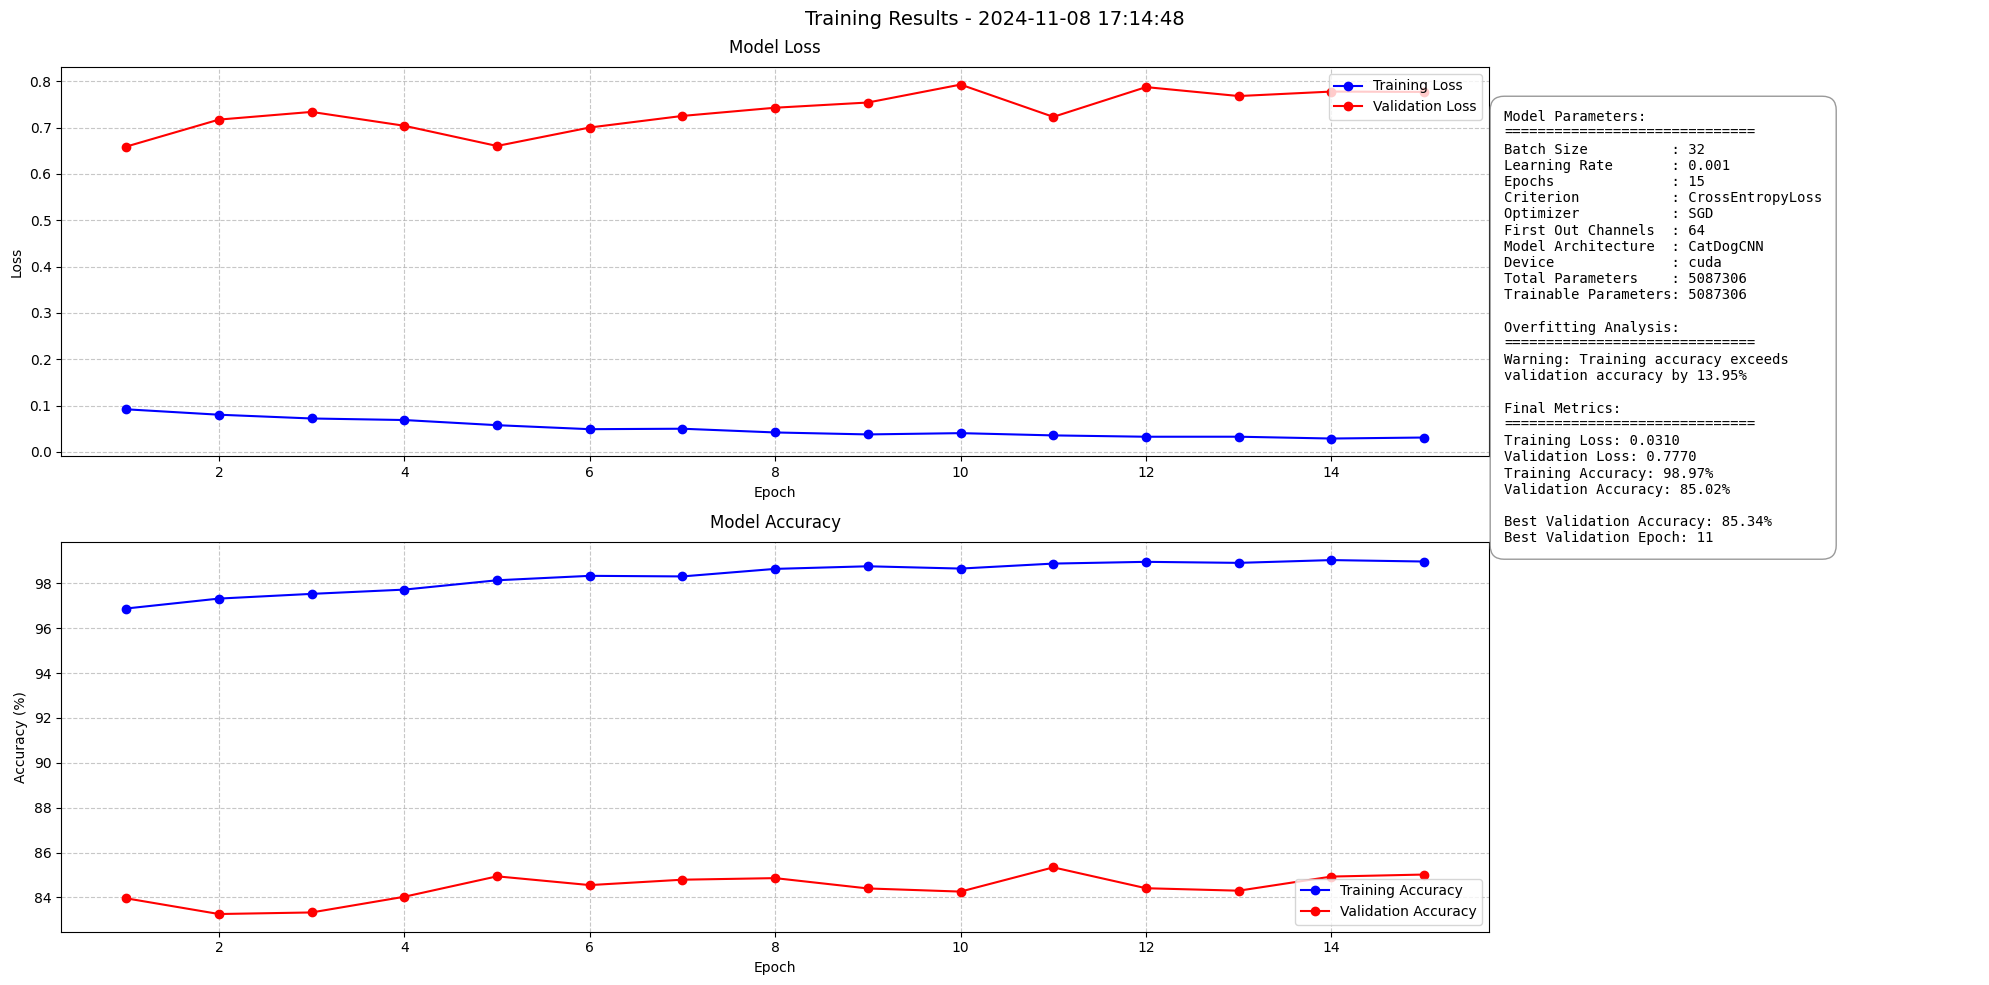

In [61]:
tracker = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=NUM_EPOCHS,
    device=device
)